<a href="https://colab.research.google.com/github/IshtiSikder/Optimal-allocation-of-rescue-teams-for-hostage-situations/blob/main/R_for_MDP_(ORG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$Iteration
[1] 3

$PolicyChange
     terror 0 terror 1 terror 2 terror 3 terror 4 terror 5 terror 6 terror 7
[1,]        1        1        1        1        1        1        1        1
[2,]        0        0        0        0        0        1        1        1
[3,]        0        0        0        1        1        1        1        1
[4,]        0        0        0        1        1        1        1        1
     terror 8 terror 9 terror 10
[1,]        1        1         1
[2,]        1        1         1
[3,]        1        1         2
[4,]        1        1         2

$Gain
[1] 20.154361  3.991726  3.716006

$SteadyStateProb
             terror 0  terror 1  terror 2   terror 3   terror 4    terror 5
Probability 0.4174762 0.3357063 0.1799683 0.05125784 0.01240261 0.002608542
                terror 6     terror 7     terror 8     terror 9    terror 10
Probability 0.0004851836 8.088832e-05 1.221882e-05 1.687271e-06 2.041303e-07

$Optimal_policy
         terror 0 terror 1 terror 2 terror 3 terror 4 terror 5 terror 6
Decision        0        0        0        1        1        1        1
         terror 7 terror 8 terror 9 terror 10
Decision        1        1        1         2

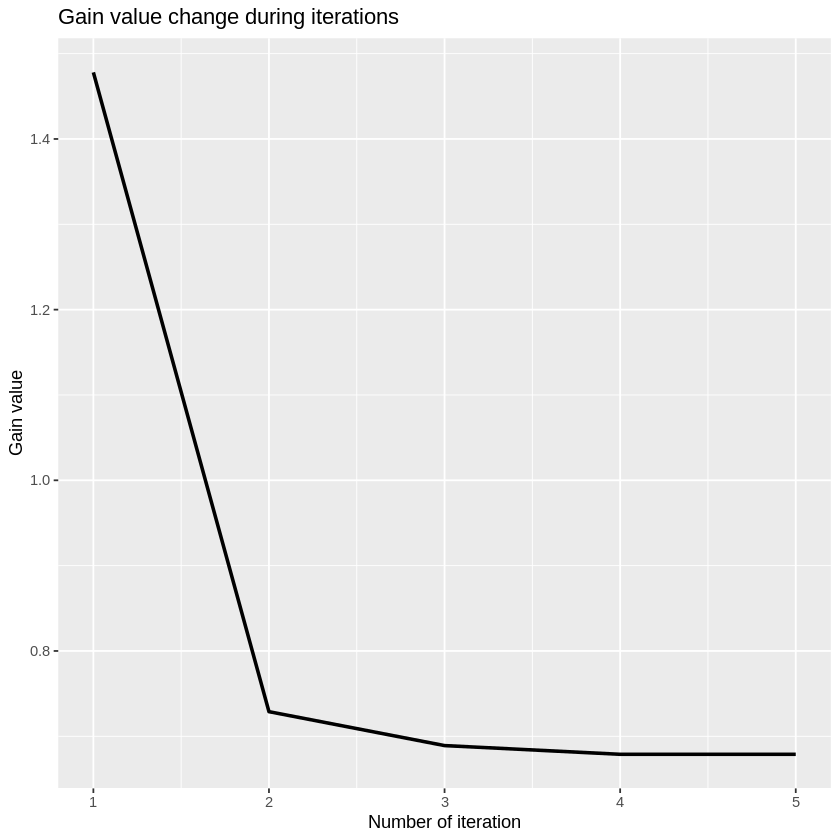

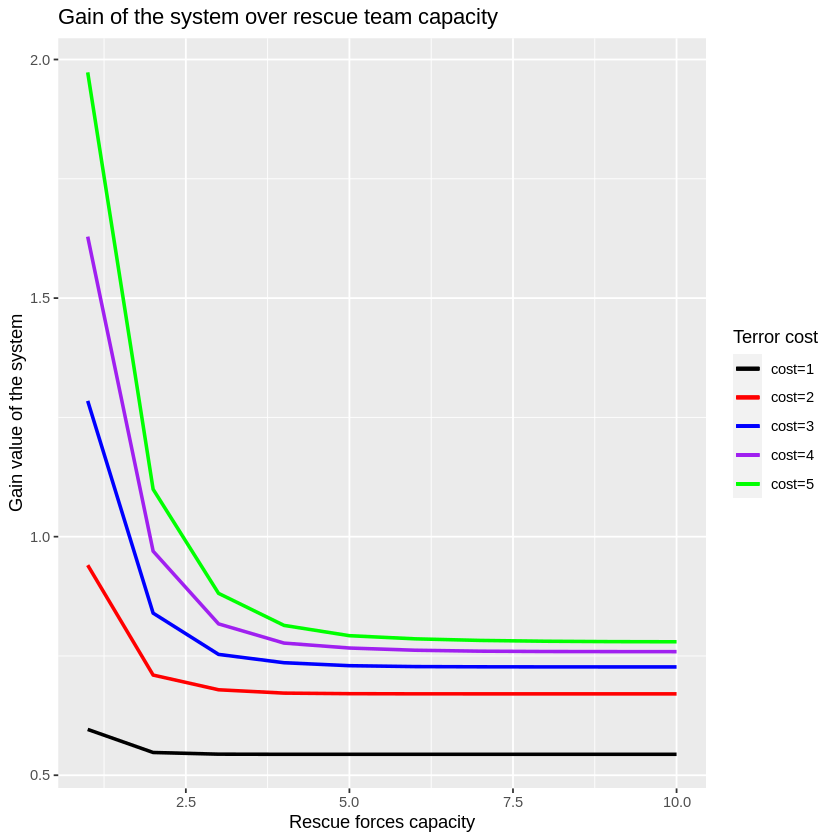

In [12]:
# CTMC MDP model for rescue operational system!!!
# For steady state prob for optimal policy
prob <- function(opSet = policySet, t, lam, eps, mu) {
  opTRM = matrix(0, nrow = t+1, ncol = t+1)
  for (i in 2:t) {
    opTRM[i, i-1] = sum(i*eps, opSet[i]*mu)
    opTRM[i, i+1] = lam      
  }
  opTRM[1, 2] = lam
  opTRM[t+1, t] = sum(t*eps, opSet[t+1]*mu)
  
  k = t+1
  steady_prob <- matrix(0, nrow=1, ncol=k)
  state <- matrix(0, nrow=1, ncol=k-1)
  for (i in 1:(k-1)) {
    if (i-2 < 0) {
      state[i] <- (lam/opTRM[i+1,i])
    } else {
      state[i] <- state[i-1]*(lam/opTRM[i+1,i])
    }
  }
  
  steady_prob[1] <- (1+sum(state))^-1
  for (i in 2:k) {
    steady_prob[i] <- state[i-1]*steady_prob[1]
  }
  return(steady_prob)
}

# Check function to determine new policy is same with current or not 
checkPolicy = function(policySet, policySetnew) {
  n = 0
  for (i in policySet == policySetnew) {
    if (i == 'FALSE') {
      n = 1
    } 
  } 
  if (n == 0) {
    return("TRUE")
  } else {
    return("FALSE")
  }
} 

rewardR <- function(costR, RC, nr) {
  if (RC == "SR") {
    if (costR < 0) {
      result = -sqrt(-costR * nr)      
    } else {
      result = sqrt(costR * nr)
    }
  } else if (RC == "L") {
    result = costR * nr      
  } else {
    if (costR < 0) {
      result = -(costR * nr)^2      
    } else {
      result = (costR * nr)^2      
    }
  }
  return(result)
}

rewardT <- function(costT, TC, nt) {
  if (TC == "SR") {
    if (costT < 0) {
      result = -sqrt(-costT * nt)      
    } else {
      result = sqrt(costT * nt)
    }
  } else if (TC == "L") {
    result = costT * nt      
  } else {
    if (costT < 0) {
      result = -(costT * nt)^2      
    } else {
      result = (costT * nt)^2      
    }
  }
  return(result)
}

probR = function(nr, nt, eps, mu) {
  if (nt == 0 & nr == 0) {
    result = 0
  } else {
    result = nr*mu / (nr*mu + nt*eps)
  }
  return(result)
}

# Define MDP function (for basic policy)
MDP = function(lam, mu, eps, numRescue, numTerror, costR, costT, RC, TC) {
  r = numRescue
  t = numTerror
  # Design the three dimension matrix(i,j,k)
  # k: Index of rescue team
  # i: state(current)
  # j: state(next)
  
  aijMatrix = array(0, dim = c(t+1,t+1,r+1))
  for (k in 1:(r+1)) {
    for (i in 1:t) {
      aijMatrix[i,i+1,k] <- lam
      if (i > 1) {
        aijMatrix[i,i-1,k] <- sum((k-1)*mu+(i-1)*eps)        
      }
    }
    aijMatrix[t+1,t,k] <- ((k-1)*mu+t*eps)
    aijMatrix[1,2,k] <- lam
  }
  
  
  # Transition probability
  for (k in 1:(r+1)) {
    for (i in 1:(t+1)) {
      aijMatrix[i,i,k] <- -sum(aijMatrix[i,,k])      
    }
  }
  
  # Design the MDP algorithm
  # Value determination
  policy = array(0, dim = c(1,t+1)) 
  policyOld = array(0, dim = c(1,t+1))
  policyNew = array(2, dim=c(1,t+1)) # initially set all decision is 1 in first policy
  policyTrack = array(2, dim=c(1,t+1))
  iteration = 0
  gainMatrix = c()
  
  while (checkPolicy(policyOld, policyNew) == 'FALSE') {
    policyOld = policyNew
    policy = policyNew
    # Design the transition matrix regarding policy
    A = array(0, dim = c(t+1,t+1))
    for (i in 1:length(policy)) {
      A[i,] = aijMatrix[i,,(policy[i])]  
    }

    # Design the cost matrix regarding policy
    q = array(0, dim = c(t+1,1))
    for (i in 1:length(policy)) {
      cost = probR(nr=(policy[i]-1),nt=(i-1),eps,mu)*rewardR(costR, RC, nr=(policy[i]-1))+
        (1-probR(nr=(policy[i]-1),nt=(i-1),eps,mu))*rewardT(costT, TC, nt=(i-1))
      q[i,1] = cost
    }
    newA = cbind(array(1, dim=c(t+1,1)), -A[,1:t])
    solution = solve(newA) %*% q
    gain = solution[1] # First row of solution is gain value
    gainMatrix = append(gainMatrix, gain)
    
    # Policy improvement
    newsolution = array(0, dim=c(t+1,1))
    for (i in 1:t) {
      newsolution[i] = solution[i+1]
    }
    newsolution[t+1] = 0 # Set last v value as 0 to calcultate the test quantity in policy improvement
    improveMatrix = array(0, dim=c(t+1,r+1))
    for (i in 1:(t+1)) {
      for (j in 1:(r+1)) {
        # Cost when we have j rescue operation and i terrorists
        cost = probR(nr=(j-1),nt=(i-1),eps,mu)*rewardR(costR, RC, nr=(j-1))+
          (1-probR(nr=(j-1),nt=(i-1),eps,mu))*rewardT(costT, TC, nt=(i-1))
        improveMatrix[i,j] = cost + aijMatrix[i,,j] %*% newsolution
      }
    }  
    
    # pick the minimum value among the decision
    policyNew = array(1, dim = c(1,t+1))
    for (i in 1:length(policyNew)) {
      policyNew[i] = which.min(improveMatrix[i,])
    }
    iteration = iteration + 1
    policyTrack = rbind(policyTrack, policyNew)
    policyNew
  }
  for (i in 1:length(policyNew)) {
    policyNew[i] = policyNew[i] - 1
  }
  for (i in 1:nrow(policyTrack)) {
    for (j in 1:ncol(policyTrack)) {
      policyTrack[i,j] = policyTrack[i,j] - 1      
    }

  }
  stateName = c()
  for (i in 1:(t+1)) {
    stateName = append(stateName, paste('terror',(i-1)))
  }
  Steady_prob = prob(opSet = policyNew, t, lam, eps, mu)  
  colnames(policyTrack) = stateName
  colnames(policyNew) = stateName
  colnames(Steady_prob) = stateName
  rownames(Steady_prob) = 'Probability'
  rownames(policyNew) = 'Decision'
  result <- list("Iteration" = iteration,
                 "PolicyChange" = policyTrack,
                 "Gain" = gainMatrix,
                 "SteadyStateProb" = Steady_prob,
                 "Optimal_policy" = policyNew)
  return(result)
}
MDP(lam = 0.2763, mu = 0.2829, eps = 0.1718, numRescue=10, numTerror=10, costR=5, costT=1, RC="QD", TC="QD")
A = MDP(lam = 0.3546, mu = 0.2829, eps = 0.1718, numRescue=10, numTerror=10, costR=1, costT=1, RC="L", TC="L")


 

# 1 more iteration for example plot
library(ggplot2)
result = MDP(lam = 0.2473, mu = 0.2829, eps = 0.1718, numRescue=3, numTerror=5, costR=1, costT=2, RC="L", TC="L")
result = result$Gain
ddd = array(0, dim=c(5,2))
for (i in 1:5) {
  ddd[i,1] = i
  ddd[i,2] = result[i]  
}
ddd[5,1] = 5
ddd[5,2] = ddd[4,2]

ddd = as.data.frame(ddd)
ggplot(ddd, aes(x=V1, y=V2)) +
  geom_line(size=1) +
  labs(x = 'Number of iteration', y = 'Gain value',
       title = 'Gain value change during iterations')


# Experiment design
rescueSet = c(1,2,3,4,5,6,7,8,9,10)
gainResult = array(0, dim=c(5,length(rescueSet)))
for (j in 1:5) {
  for (i in 1:length(rescueSet)) {
    val = rescueSet[i]
    result = MDP(lam=0.2473, mu=0.2829, eps=0.1718, numRescue=val, numTerror=10, costR=1, costT=j, RC="L", TC="L")
    gainResult[j,i] = tail(result$Gain, 1)
  }  
}
gainResult = as.data.frame(t(gainResult))
gainResult$index = rescueSet
ggplot() +
  geom_line(data=gainResult, aes(x=index, y=V1, color='black'), size=1) +
  geom_line(data=gainResult, aes(x=index, y=V2, color='red'), size=1) +
  geom_line(data=gainResult, aes(x=index, y=V3, color='blue'), size=1) +
  geom_line(data=gainResult, aes(x=index, y=V4, color='purple'), size=1) +
  geom_line(data=gainResult, aes(x=index, y=V5, color='green'), size=1) +
  labs(x = 'Rescue forces capacity', y = 'Gain value of the system',
       title = 'Gain of the system over rescue team capacity') +
  scale_color_identity(name = "Terror cost",
                       labels = c("cost=1", "cost=2", "cost=3", "cost=4", "cost=5"),
                       breaks = c("black", "red", "blue", "purple", "green"),
                       guide = "legend")

In [13]:
MDP(lam = 0.2763, mu = 0.2829, eps = 0.1718, numRescue=10, numTerror=10, costR=1, costT=2, RC="L", TC="QD")

$Iteration
[1] 4

$PolicyChange
     terror 0 terror 1 terror 2 terror 3 terror 4 terror 5 terror 6 terror 7
[1,]        1        1        1        1        1        1        1        1
[2,]        0       10       10       10       10       10       10       10
[3,]        0        5       10       10       10       10       10       10
[4,]        0        4       10       10       10       10       10       10
[5,]        0        4       10       10       10       10       10       10
     terror 8 terror 9 terror 10
[1,]        1        1         1
[2,]       10       10        10
[3,]       10       10        10
[4,]       10       10        10
[5,]       10       10        10

$Gain
[1] 4.4178930 0.8948010 0.8678972 0.8673692

$SteadyStateProb
             terror 0  terror 1   terror 2    terror 3    terror 4     terror 5
Probability 0.8305066 0.1555511 0.01285097 0.001009818 7.56542e-05 5.415632e-06
                terror 6     terror 7     terror 8     terror 9    terror 10
Probability 3.711527e-07 2.439679e-08 1.540692e-09 9.362065e-11 5.688891e-12

$Optimal_policy
         terror 0 terror 1 terror 2 terror 3 terror 4 terror 5 terror 6
Decision        0        4       10       10       10       10       10
         terror 7 terror 8 terror 9 terror 10
Decision       10       10       10        10